## Configuration

### Imports

In [1]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd
from fastprogress import master_bar, progress_bar

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Network analysis
import networkx as nx
import graph_tool.all as gt

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

### Support Functions

In [2]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None

    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.rename(columns={'user_id':'tweet_author'},inplace=True)
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.rename(columns={'user_id':'retweet_author'},inplace=True)
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                )
    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

## Data Preparation

#### Getting tweets from DB...

In [3]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,tweet_author,tweet_id
0,000000000000000279465279,000001191464087064109058
1,000000000000001266667238,000001192787272975945729
2,000000000000000331220696,000001191467194519080960


In [4]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweet_author  358190 non-null  object
 1   tweet_id      358190 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


In [5]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### Getting retweets from DB...

In [6]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 7868861


,tweet_id,retweet_author
0,000001193667913368121351,000000000000004460826197
1,000001192581634291355649,000001075150211725619200
2,000001190659978471911424,000000000000000071190801


In [7]:
df_retweets[df_retweets.duplicated()].count()

tweet_id          3525
retweet_author    3525
dtype: int64

In [8]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id          7865336
retweet_author    7865336
dtype: int64

#### Getting users from DB...

In [9]:
users = get_users(db.users)
display(users.head(5))

Number of sampled users with botscore in DB: 1150709


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000006953012,0.03


In [10]:
len(users._id.unique())

1150709

### Build directed-weighted retweet graph

In [11]:
df_edges = df_retweets.set_index('tweet_id').join(df_tweets.set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,retweet_author,tweet_author
0,000001041608534734061568,000000000000000068740712
1,000000000000002824508322,000000000000000068740712
2,000000755192640321314817,000000000000000068740712
3,000000000000000523370717,000000000000000068740712
4,000000000000003610966882,000000000000000068740712


In [12]:
df_edges = df_edges.groupby(['retweet_author','tweet_author']).size().reset_index().rename(columns={0:'weight'})
df_edges.head(5)

,retweet_author,tweet_author,weight
0,000000000000000000002862,000000000000000026994875,1
1,000000000000000000003065,000000000000000016409683,1
2,000000000000000000003065,000000000000000121385551,1
3,000000000000000000003065,000000000000000207741909,1
4,000000000000000000003968,000000000000000014436030,1


In [13]:
implicated_users = []
implicated_users = list(set(list(df_edges.retweet_author.unique()) + list(df_edges.tweet_author.unique())))
#print("Implicated users:", len(implicated_users))

df_users = users[users._id.isin(implicated_users)]
print("Users with botscore:", len(df_users))

print("Retweets without botscore:", len(df_edges))
df_edges = df_edges[(df_edges.retweet_author.isin(df_users._id)) & (df_edges.tweet_author.isin(df_users._id))]
print("Retweets with botscore:", len(df_edges))

Users with botscore: 1150709
Retweets without botscore: 6037031
Retweets with botscore: 4313219


### Networkx

In [14]:
G = nx.from_pandas_edgelist(df=df_edges, source='tweet_author', target='retweet_author', edge_attr='weight', create_using=nx.DiGraph)
node_attr = df_users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

### Using graph-tool

In [15]:
%%time

X = gt.Graph(directed=True)
eweight = X.new_edge_property('int')
user_ids = X.add_edge_list(df_edges.values, hashed=True, hash_type='string', eprops=[eweight])

CPU times: user 13.2 s, sys: 272 ms, total: 13.4 s
Wall time: 13.3 s


In [16]:
%%time

# botscore for nodes
user_botscores_dic = df_users.set_index('_id').to_dict('index')
node_botscores = []
for user_id in user_ids:
    node_botscore = user_botscores_dic[user_id]['botscore']
    node_botscores.append(node_botscore)

CPU times: user 4.71 s, sys: 168 ms, total: 4.87 s
Wall time: 4.87 s


In [17]:
%%time
vbotscores = X.new_vertex_property(value_type='float', vals=node_botscores)

CPU times: user 175 ms, sys: 7.53 ms, total: 183 ms
Wall time: 181 ms


## 1. Influence

#### Relationship botscore vs influence metrics

In [18]:
X.num_vertices()

1027305

In [19]:
%%time

eig, authorities, hubs = gt.hits(g=X, weight=eweight)
pagerank = gt.pagerank(X, weight=eweight, damping=0.85)
eigenvector = gt.eigenvector(g=X, weight=eweight)[1]

df_if = pd.DataFrame.from_dict({'Page Rank': pagerank,
                                'HITS Hub': hubs,
                                'HITS Authority': authorities,
                                'Eigenvector': eigenvector,
                                'botscore': node_botscores,
                               },
                               orient='columns')

df_if.head()

CPU times: user 1min 16s, sys: 605 ms, total: 1min 17s
Wall time: 23.8 s


,Page Rank,HITS Hub,HITS Authority,Eigenvector,botscore
0,2.590218e-07,1.087385e-14,0.000000e+00,0.000000e+00,0.09
1,8.173064e-07,1.447230e-07,2.099223e-11,0.000000e+00,0.06
2,2.590218e-07,1.310503e-06,0.000000e+00,0.000000e+00,0.05
3,1.580772e-03,2.314258e-06,2.529959e-03,1.918914e-02,0.01
4,5.150978e-06,9.789150e-09,6.147795e-09,1.726231e-17,0.12


In [20]:
normalized_df=(df_if-df_if.min())/(df_if.max()-df_if.min())
normalized_df.head(2)

,Page Rank,HITS Hub,HITS Authority,Eigenvector,botscore
0,0.000000,4.227405e-14,0.000000e+00,0.0,0.09
1,0.000036,5.626368e-07,2.213596e-11,0.0,0.06


In [21]:
normalized_df.tail()

,Page Rank,HITS Hub,HITS Authority,Eigenvector,botscore
1027300,0.0,1.329063e-10,0.0,0.0,0.15
1027301,0.0,1.217103e-06,0.0,0.0,0.33
1027302,0.0,1.420428e-10,0.0,0.0,0.40
1027303,0.0,2.079911e-11,0.0,0.0,0.36
1027304,0.0,1.280540e-09,0.0,0.0,0.60


CPU times: user 30.8 s, sys: 326 ms, total: 31.1 s
Wall time: 30.9 s


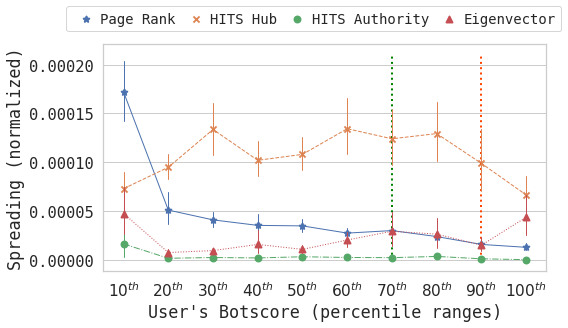

In [85]:
%%time

df_pointplot = pd.melt(normalized_df, 
                       id_vars='botscore',
                       var_name='Metric')

df_pointplot['bins_botscore'] = pd.qcut(df_pointplot.botscore, q=10, labels=['$10^{th}$','$20^{th}$','$30^{th}$','$40^{th}$','$50^{th}$','$60^{th}$','$70^{th}$','$80^{th}$','$90^{th}$','$100^{th}$'])

fig = plt.figure(figsize=(8,5))

ax = sns.pointplot(data=df_pointplot,
              x='bins_botscore',
              y='value',
              hue='Metric',
              #errwidth=0.5,
              scale=0.9,
              markers=['*','x','o', '^'],
              linestyles=["-", "--", "-.", "dotted"],
              #dodge=True,
              join=True
                  )

plt.legend(loc='upper left', ncol=4, mode='expand', bbox_to_anchor=(-0.10, 1.1, 1.15, .1), fontsize=14, handletextpad=0.02)



ax.set_ylabel(ylabel='Spreading (normalized)')
ax.set_xlabel(xlabel='User\'s Botscore (percentile ranges)')

prs = [6,8]
ps = [0.19, 0.37]

colors = {6 : 'green',
          8 : 'orangered'}

h_ylims = ax.get_ylim()


for pr,p in zip(prs,ps):
    ax.vlines(x=pr, ymin=0, ymax=0.00021, linewidth = 2, linestyles='dotted', color=colors[pr])



plt.setp(ax.lines,linewidth=1)
plt.tight_layout()
plt.savefig("images/spreading.pdf")
plt.savefig("images/spreading.svg")